In [384]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import pickle as pkl
from tabulate import tabulate

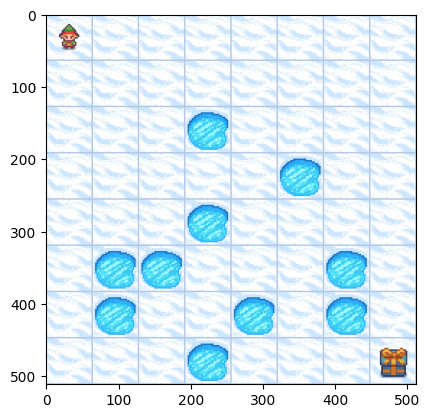

In [385]:
# Create the environment
env  = gym.make('FrozenLake-v1', is_slippery=True, map_name='8x8', render_mode='rgb_array')    
grid_height, grid_width  = env.unwrapped.desc.shape
env.reset()
plt.imshow(env.render())

In [386]:
print('Action space: ', env.action_space)
print('Observation space: ', env.observation_space)

Action space:  Discrete(4)
Observation space:  Discrete(64)


In [387]:
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(64, 4)

In [388]:
# I am gonna use this helper function, that I got from lecture note
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

In [389]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)

In [ ]:
# Hyperparameters: 
# I increased the number of episodes, because the environment is more complex 
episodes = 70000
# Since Frozen lake is slippery and has 64 states, I increased the number of steps
max_steps = 200
learning_rate = 0.3
gamma = 0.95
# For giving more chance to exploration, I increased the epsilon         
epsilon = 1.0        
max_epsilon = 1.0
min_epsilon = 0.07
decay_rate = 0.0001

### Training Loop

In [ ]:
for episode in range(episodes):

    state, __ = env.reset()
    done = False
    total_reward = 0
    
    for step in range(max_steps):
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(Q_table[state, :])
        else:
            action = env.action_space.sample()
            
        
        next_state, reward, done, truncated, __ = env.step(action)
        # I am gonna penalize each step taken 
        reward = reward - 0.01  
        
        if done and reward <=0:
            # -1 reward for falling in the hole
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, next_state, learning_rate, gamma)
            total_reward += reward
            break 
        
        Q_table = calculate_value(Q_table, state, action, reward, next_state, learning_rate, gamma)
        state = next_state  
        total_reward += reward
        
        if done:
            print(f'Step taken:{step}')
            break
        
        # Save the Q-table
        if episode % 70000 == 0:
            with open('data/q_table.pkl', 'wb') as f:
                pkl.dump(Q_table, f)
                
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    if total_reward >=0 :
        print(f"Episode {episode} done with total rewards: {total_reward:.3f}, epsilon: {epsilon:.3f}")
# I got the main structure of the code from the lecture note. 

Step taken:58
Episode 498 done with total rewards: 0.410, epsilon: 0.955
Step taken:66
Episode 594 done with total rewards: 0.330, epsilon: 0.946
Step taken:53
Episode 687 done with total rewards: 0.460, epsilon: 0.938
Step taken:76
Episode 1730 done with total rewards: 0.230, epsilon: 0.852
Step taken:72
Episode 1739 done with total rewards: 0.270, epsilon: 0.852
Step taken:94
Episode 1749 done with total rewards: 0.050, epsilon: 0.851
Step taken:49
Episode 2312 done with total rewards: 0.500, epsilon: 0.808
Step taken:57
Episode 2386 done with total rewards: 0.420, epsilon: 0.803
Step taken:154
Step taken:114
Step taken:46
Episode 2659 done with total rewards: 0.530, epsilon: 0.783
Step taken:25
Episode 2941 done with total rewards: 0.740, epsilon: 0.763
Step taken:54
Episode 2987 done with total rewards: 0.450, epsilon: 0.760
Step taken:65
Episode 3033 done with total rewards: 0.340, epsilon: 0.757
Step taken:124
Step taken:77
Episode 3250 done with total rewards: 0.220, epsilon: 0.

In [392]:
# Applying the summarize best value function
best_values = summarize_best_values(Q_table, grid_width, grid_height)
print('Q_table after Training:')
print(tabulate(best_values, tablefmt='fancy_grid', floatfmt='.2f'))

Q_table after Training:
╒═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ -0.16 │ -0.15 │ -0.12 │ -0.10 │ -0.07 │ -0.06 │ -0.04 │ -0.01 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.16 │ -0.15 │ -0.13 │ -0.11 │ -0.07 │ -0.06 │ -0.03 │  0.05 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.17 │ -0.17 │ -0.27 │  0.00 │ -0.33 │ -0.14 │  0.01 │  0.09 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.18 │ -0.18 │ -0.34 │ -0.67 │ -0.42 │  0.00 │  0.02 │  0.20 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.19 │ -0.20 │ -0.45 │  0.00 │ -0.34 │ -0.39 │  0.17 │  0.40 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.19 │  0.00 │  0.00 │ -0.81 │ -0.50 │ -0.69 │  0.00 │  0.58 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.19 │  0.00 │ -0.70 │ -0.88 │  0.00 │ -0.67 │  0.00 │  0.85 │
├───────┼───────┼───────┼───────┼───────┼───────┼───

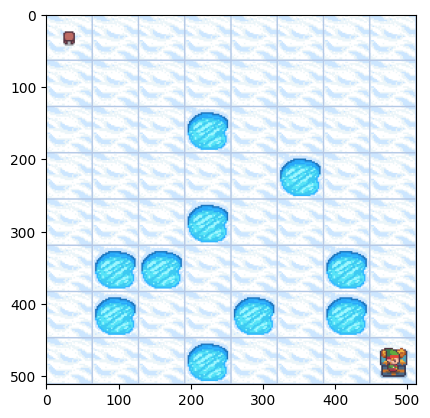

Episode 3: Steps taken: 193, Total Reward: 1.0


In [393]:
env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

for episode in range(3):
    state, __ = env.reset()
    done = False
    total_reward = 0
    
    
    
    for step in range(max_steps):
    
        action = np.argmax(Q_table[state, :])
        next_sate, reward, done, truncated, __ = env.step(action)
        total_reward = total_reward + reward
        
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()
    
        if done:
            print(f'Episode {episode+1}: Steps taken: {step}, Total Reward: {total_reward}')
            time.sleep(2)
            break
        
        state = next_sate
        time.sleep(0.3)